**Thành Viên: Phạm Đức Thể, Trần Triệu Vũ, Võ Minh Trí**

**MSSV: 19522253, 19522539, 19522396**

**Lớp: DS200.M21**

**Nội Dung: [Bài tập Kaggle 2](https://www.kaggle.com/competitions/kaggle-assignment-2)**

**[Dataset](https://drive.google.com/drive/folders/1_4D3P1j26LUR2DJ5hQQ7P3HID9Sd2Tfu?usp=sharing)**

**Ngày: 26/05/2022** 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10xQLBclmnk7uEE5JpD_cscgEVDslIfXT?usp=sharing)

# **Big Data - UIT DS200 Kaggle Assignment 6**

## **Import Library**

In [ ]:
!pip install pyspark==3.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 204.2 MB 39 kB/s 
     |████████████████████████████████| 198 kB 65.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=2e539403a9605289de230a69d5104074a1d5e88d7ffd4eebbc9f86801aeae482
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


In [ ]:
import numpy as np
import pandas
import time
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StopWordsRemover, RegexTokenizer, HashingTF, IDF, Tokenizer, CountVectorizer, Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pprint import pprint
from textblob import TextBlob

sns.set()

spark = SparkSession.builder.appName('BigDataAssignment6').config("spark.executor.memory","8g").getOrCreate()
spark

## **Read Data**

In [ ]:
PATH = '/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 2 2021 - 2022/DS200.M21 - PHÂN TÍCH DỮ LIỆU LỚN/THỰC HÀNH/LAB/Assignment06 - 25 05 2022/Dataset/'
schemaTrain = 'polarity FLOAT, id LONG, date_time STRING, query STRING, user STRING, text STRING'
schemaTest = "id LONG, date_time STRING, query STRING, user STRING, text STRING"

In [ ]:
# Read train.csv
train_data = spark.read.csv(PATH+'train.csv', header=True, schema=schemaTrain)
train_data.printSchema()
train_data.show(20,False)
train_data.count()

root
 |-- polarity: float (nullable = true)
 |-- id: long (nullable = true)
 |-- date_time: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+--------+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|polarity|id        |date_time                   |query   |user           |text                                                                                                                 |
+--------+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|0.0     |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D 

1600000

In [ ]:
# Read train.csv
test_data = spark.read.csv(PATH+'test.csv', header=True, schema=schemaTest)
test_data.printSchema()
test_data.show(20,False)
test_data.count()

root
 |-- id: long (nullable = true)
 |-- date_time: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+---+----------------------------+-------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|id |date_time                   |query  |user          |text                                                                                                                                        |
+---+----------------------------+-------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|3  |Mon May 11 03:17:40 UTC 2009|kindle2|tpryan        |@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.                             |
|4  |Mon May 11 

498

In [ ]:
# Chọn các thuộc tính để training
train = train_data.select('id','text','polarity')
train.printSchema()
train.show(20,False)
train.count()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- polarity: float (nullable = true)

+----------+---------------------------------------------------------------------------------------------------------------------+--------+
|id        |text                                                                                                                 |polarity|
+----------+---------------------------------------------------------------------------------------------------------------------+--------+
|1467810369|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |0.0     |
|1467810672|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |0.0     |
|1467810917|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                            |0.0     |
|1467811184|my whole body feels itchy and like 

1600000

In [ ]:
# Chọn các thuộc tính để test model vừa training được
test = test_data.select('id','text')
test.printSchema()
test.show(20,False)
test.count()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)

+---+--------------------------------------------------------------------------------------------------------------------------------------------+
|id |text                                                                                                                                        |
+---+--------------------------------------------------------------------------------------------------------------------------------------------+
|3  |@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.                             |
|4  |Reading my kindle2...  Love it... Lee childs is good read.                                                                                  |
|5  |Ok, first assesment of the #kindle2 ...it fucking rocks!!!                                                                                  |
|6  |@kenburbary You'll love your Kindle2. I

498

### distribution of polarity train

No of rows with Polarity: 1600000/1600000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


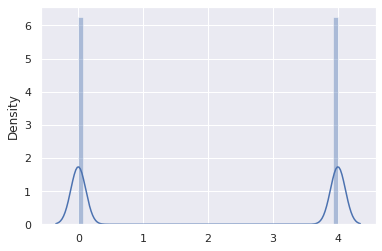

In [ ]:
df = train.select('polarity').na.drop()
print(f'No of rows with Polarity: {df.count()}/{train.count()}')
# Xem phân phối của các label của tập dữ liệu
sns.distplot(df.toPandas())

In [ ]:
polarity_df = train.select('polarity').cache()

polarity_df.groupBy('polarity').count().toPandas()

,polarity,count
0,4.0,800000
1,0.0,800000


### Encode train polarity

In [ ]:
# train = train.withColumn('polarity',f.when(f.col('polarity')==4, 2).otherwise(0))

In [ ]:
# df = train.select('polarity').na.drop()
# print(f'No of rows with Polarity: {df.count()}/{train.count()}')

# sns.distplot(df.toPandas())

In [ ]:
# polarity_df = train.select('polarity').cache()

# polarity_df.groupBy('polarity').count().toPandas()

## **Text Pre-processing**

In [ ]:
user_regex = r"(@\w{1,15})"
hashtag_replace_regex = "#(\w{1,})"
url_regex = r"((https?|ftp|file):\/{2,3})+([-\w+&@#/%=~|$?!:,.]*)|(www.)+([-\w+&@#/%=~|$?!:,.]*)"
email_regex = r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"
i_regex = r"i "
# Định nghĩa hàm chuẩn hóa lại text trong tập dữ liệu
def cleaning_process(data):
          # Loại bỏ @Mention khỏi text
  data_new=(data.withColumn("text",f.regexp_replace(f.col("text"), user_regex, "")) 
          # Loại bỏ #Hashtag khỏi text
          .withColumn("text",f.regexp_replace(f.col("text"), hashtag_replace_regex, "$1"))
          # Loại bỏ URL khỏi text
          .withColumn("text",f.regexp_replace(f.col("text"), url_regex, "")) 
          # Loại bỏ Email khỏi text
          .withColumn("text",f.regexp_replace(f.col("text"), email_regex, ""))
          # Loại bỏ số cũng như các ký tự khỏi đoạn text
          .withColumn("text",f.regexp_replace(f.col("text"), "[^a-zA-Z]", " "))
          # Loại bỏ các khoảng trắng thừa trong câu
          .withColumn("text",f.regexp_replace(f.col("text"), " +", " "))
          # Loại vỏ các khoảng trắng đầu và cuối câu
          .withColumn("text",f.trim(f.col("text")))
          # Chuẩn hoá viết thường
          .withColumn("text",f.lower(f.col("text")))
          # Loại bỏ các dữ liệu mà text không có nôi dung
          .filter(f.col("text") != ""))
  return data_new

In [ ]:
Train = cleaning_process(train)
Train.show(10, False)
Train.count()

+----------+---------------------------------------------------------------------------------------------------------+--------+
|id        |text                                                                                                     |polarity|
+----------+---------------------------------------------------------------------------------------------------------+--------+
|1467810369|a that s a bummer you shoulda got david carr of third day to do it d                                     |0.0     |
|1467810672|is upset that he can t update his facebook by texting it and might cry as a result school today also blah|0.0     |
|1467810917|i dived many times for the ball managed to save the rest go out of bounds                                |0.0     |
|1467811184|my whole body feels itchy and like its on fire                                                           |0.0     |
|1467811193|no it s not behaving at all i m mad why am i here because i can t see you all over there    

1596303

In [ ]:
Test = cleaning_process(test)
Test.show(10, False)
Test.count()

+---+------------------------------------------------------------------------------------------------------------------------+
|id |text                                                                                                                    |
+---+------------------------------------------------------------------------------------------------------------------------+
|3  |i loooooooovvvvvveee my kindle not that the dx is cool but the is fantastic in its own right                            |
|4  |reading my kindle love it lee childs is good read                                                                       |
|5  |ok first assesment of the kindle it fucking rocks                                                                       |
|6  |you ll love your kindle i ve had mine for a few months and never looked back the new big one is huge no need for remorse|
|7  |fair enough but i have the kindle and i think it s perfect                                                

498

## **Build Model**

### Build Pipeline

In [ ]:
# Create pipeline processing data and model
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="words1", 
                                     stopWords=StopWordsRemover.loadDefaultStopWords("english"))
hashtf = HashingTF(numFeatures=2**16, inputCol="words1", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5)

lr = LogisticRegression(maxIter=100, regParam = 0.005, featuresCol="features", labelCol="polarity")

pipeline = Pipeline(stages=[regexTokenizer, stopwords_remover, hashtf, idf, lr])

### Training model

In [ ]:
%%time
# Training model
model = pipeline.fit(Train)

CPU times: user 1.53 s, sys: 192 ms, total: 1.73 s
Wall time: 5min 10s


In [ ]:
# Prediction on Train
Trained = model.transform(Train)
Trained.show()

+----------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        id|                text|polarity|               words|              words1|                  tf|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|1467810369|a that s a bummer...|     0.0|[a, that, s, a, b...|[bummer, shoulda,...|(65536,[21640,239...|(65536,[21640,239...|[9.22189861454139...|[0.89417954448215...|       0.0|
|1467810672|is upset that he ...|     0.0|[is, upset, that,...|[upset, update, f...|(65536,[16064,193...|(65536,[16064,193...|[10.0752906505553...|[0.97896901959093...|       0.0|
|1467810917|i dived many time...|     0.0|[i, dived, many, ...|[dived, many, tim...|(65536,[2548,288

In [ ]:
%%time
# Tính Accuracy đạt được trên tập train
evaluator = MulticlassClassificationEvaluator(labelCol='polarity', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')

===============Training Data===============
Accuracy: 79.05561%
CPU times: user 440 ms, sys: 53.7 ms, total: 493 ms
Wall time: 1min 19s


## **Prediction**

### Predict on Test

In [ ]:
# Model dự đoán trên tập test
predictions = model.transform(Test)
predictions.show()
predictions.count()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|                text|               words|              words1|                  tf|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  3|i loooooooovvvvvv...|[i, loooooooovvvv...|[loooooooovvvvvve...|(65536,[2568,1792...|(65536,[2568,1792...|[7.49297259141157...|[0.21025761182210...|       4.0|
|  4|reading my kindle...|[reading, my, kin...|[reading, kindle,...|(65536,[7472,4789...|(65536,[7472,4789...|[7.14973683689246...|[0.11815470628759...|       4.0|
|  5|ok first assesmen...|[ok, first, asses...|[ok, first, asses...|(65536,[1527,1589...|(65536,[1527,1589...|[7.47802048905373...|[0.20533512629511...|       4.0|
|  6|you ll love

498

In [ ]:
# Chọn ra các thuộc tính cần thiết để tính toán và xử lý.
pred = predictions.select('id', 'text', 'probability', 'prediction')
pred.show()
pred.count()

+---+--------------------+--------------------+----------+
| id|                text|         probability|prediction|
+---+--------------------+--------------------+----------+
|  3|i loooooooovvvvvv...|[0.21025761182210...|       4.0|
|  4|reading my kindle...|[0.11815470628759...|       4.0|
|  5|ok first assesmen...|[0.20533512629511...|       4.0|
|  6|you ll love your ...|[0.72471771992731...|       0.0|
|  7|fair enough but i...|[0.50428193261109...|       0.0|
|  8|no it is too big ...|[0.14514280637435...|       4.0|
|  9|fuck this economy...|[0.97589269109037...|       0.0|
| 10|jquery is my new ...|[0.15165939991052...|       4.0|
| 11|       loves twitter|[0.17182208842118...|       4.0|
| 12|how can you not l...|[0.15904202091329...|       4.0|
| 13|check this video ...|[0.18957251659826...|       4.0|
| 14|i firmly believe ...|[0.93503766823887...|       0.0|
| 15|house corresponde...|[0.48048531691643...|       4.0|
| 16|watchin espn jus ...|[0.21632398773189...|       4.

498

In [ ]:
# Sử dụng phương thức TextBlob để dự đoán cảm xúc trên tập test, để so sánh với mô hình training, từ đó tiến hành chuẩn hóa lại label test.
def get_polarity(s):
  return TextBlob(s).sentiment.polarity

In [ ]:
# Thêm thuộc tính 'sentiment' khi sử dụng TextBlob để dự đoán thuộc tính 'text'
UDF = f.udf(get_polarity, FloatType())
pred = pred.withColumn('sentiment', UDF(f.col('text')))
pred.show()
pred.count()

+---+--------------------+--------------------+----------+-----------+
| id|                text|         probability|prediction|  sentiment|
+---+--------------------+--------------------+----------+-----------+
|  3|i loooooooovvvvvv...|[0.21025761182210...|       4.0| 0.40892857|
|  4|reading my kindle...|[0.11815470628759...|       4.0|        0.6|
|  5|ok first assesmen...|[0.20533512629511...|       4.0|       0.05|
|  6|you ll love your ...|[0.72471771992731...|       0.0| 0.13939394|
|  7|fair enough but i...|[0.50428193261109...|       0.0| 0.56666666|
|  8|no it is too big ...|[0.14514280637435...|       4.0|        0.4|
|  9|fuck this economy...|[0.97589269109037...|       0.0|       -0.6|
| 10|jquery is my new ...|[0.15165939991052...|       4.0|  0.5681818|
| 11|       loves twitter|[0.17182208842118...|       4.0|        0.0|
| 12|how can you not l...|[0.15904202091329...|       4.0|      -0.25|
| 13|check this video ...|[0.18957251659826...|       4.0|        0.0|
| 14|i

498

In [ ]:
# Ở thuộc tính 'sentiment' với các giá trị < 0 thì sẽ được gán là 0 (negative), 
# với các giá trị = 0 sẽ được gán là 2 (neutral), còn lại được gán là 4 (positive).
pred = pred.withColumn('polarity',f.when(f.col('sentiment')<0, 0).when(f.col('sentiment')==0, 2).otherwise(4))
pred.show()
pred.count()

+---+--------------------+--------------------+----------+-----------+--------+
| id|                text|         probability|prediction|  sentiment|polarity|
+---+--------------------+--------------------+----------+-----------+--------+
|  3|i loooooooovvvvvv...|[0.21025761182210...|       4.0| 0.40892857|       4|
|  4|reading my kindle...|[0.11815470628759...|       4.0|        0.6|       4|
|  5|ok first assesmen...|[0.20533512629511...|       4.0|       0.05|       4|
|  6|you ll love your ...|[0.72471771992731...|       0.0| 0.13939394|       4|
|  7|fair enough but i...|[0.50428193261109...|       0.0| 0.56666666|       4|
|  8|no it is too big ...|[0.14514280637435...|       4.0|        0.4|       4|
|  9|fuck this economy...|[0.97589269109037...|       0.0|       -0.6|       0|
| 10|jquery is my new ...|[0.15165939991052...|       4.0|  0.5681818|       4|
| 11|       loves twitter|[0.17182208842118...|       4.0|        0.0|       2|
| 12|how can you not l...|[0.15904202091

498

In [ ]:
# Thêm thuộc tính 'prob' bằng cách lấy từ thuộc tính 'probability' và các giá trị được lấy sau số 0 3 chứ số.
pred = pred.withColumn('prob', f.col('probability').cast("string").substr(2,5).cast("float"))
pred.show()
pred.count()

+---+--------------------+--------------------+----------+-----------+--------+-----+
| id|                text|         probability|prediction|  sentiment|polarity| prob|
+---+--------------------+--------------------+----------+-----------+--------+-----+
|  3|i loooooooovvvvvv...|[0.21025761182210...|       4.0| 0.40892857|       4| 0.21|
|  4|reading my kindle...|[0.11815470628759...|       4.0|        0.6|       4|0.118|
|  5|ok first assesmen...|[0.20533512629511...|       4.0|       0.05|       4|0.205|
|  6|you ll love your ...|[0.72471771992731...|       0.0| 0.13939394|       4|0.724|
|  7|fair enough but i...|[0.50428193261109...|       0.0| 0.56666666|       4|0.504|
|  8|no it is too big ...|[0.14514280637435...|       4.0|        0.4|       4|0.145|
|  9|fuck this economy...|[0.97589269109037...|       0.0|       -0.6|       0|0.975|
| 10|jquery is my new ...|[0.15165939991052...|       4.0|  0.5681818|       4|0.151|
| 11|       loves twitter|[0.17182208842118...|       

498

### Final Result

In [ ]:
# Thêm thuộc tính 'polarity'. 
# Với các giá trị 'polarity' = 4 và 'prob' > 0.57 thì giá trị tương ứng tại 'polarity' = 2, ngược lại các giá trị sẽ được giữ nguyên.
final = pred.withColumn('polarity', f.when((f.col('polarity')==4) & (f.col('prob')>0.57),2).otherwise(f.col('polarity')))
final.show()
final.count()

+---+--------------------+--------------------+----------+-----------+--------+-----+
| id|                text|         probability|prediction|  sentiment|polarity| prob|
+---+--------------------+--------------------+----------+-----------+--------+-----+
|  3|i loooooooovvvvvv...|[0.21025761182210...|       4.0| 0.40892857|       4| 0.21|
|  4|reading my kindle...|[0.11815470628759...|       4.0|        0.6|       4|0.118|
|  5|ok first assesmen...|[0.20533512629511...|       4.0|       0.05|       4|0.205|
|  6|you ll love your ...|[0.72471771992731...|       0.0| 0.13939394|       2|0.724|
|  7|fair enough but i...|[0.50428193261109...|       0.0| 0.56666666|       4|0.504|
|  8|no it is too big ...|[0.14514280637435...|       4.0|        0.4|       4|0.145|
|  9|fuck this economy...|[0.97589269109037...|       0.0|       -0.6|       0|0.975|
| 10|jquery is my new ...|[0.15165939991052...|       4.0|  0.5681818|       4|0.151|
| 11|       loves twitter|[0.17182208842118...|       

498

In [ ]:
# Thêm thuộc tính 'polarity'. 
# Với các giá trị 'polarity' = 2 và 'prob' > 0.62 thì giá trị tương ứng tại 'polarity' = 0, ngược lại các giá trị sẽ được giữ nguyên.
final = final.withColumn('polarity', f.when((f.col('polarity')==2) & (f.col('prob')>0.62),0).otherwise(f.col('polarity')))
final.show()
final.count()

+---+--------------------+--------------------+----------+-----------+--------+-----+
| id|                text|         probability|prediction|  sentiment|polarity| prob|
+---+--------------------+--------------------+----------+-----------+--------+-----+
|  3|i loooooooovvvvvv...|[0.21025761182210...|       4.0| 0.40892857|       4| 0.21|
|  4|reading my kindle...|[0.11815470628759...|       4.0|        0.6|       4|0.118|
|  5|ok first assesmen...|[0.20533512629511...|       4.0|       0.05|       4|0.205|
|  6|you ll love your ...|[0.72471771992731...|       0.0| 0.13939394|       0|0.724|
|  7|fair enough but i...|[0.50428193261109...|       0.0| 0.56666666|       4|0.504|
|  8|no it is too big ...|[0.14514280637435...|       4.0|        0.4|       4|0.145|
|  9|fuck this economy...|[0.97589269109037...|       0.0|       -0.6|       0|0.975|
| 10|jquery is my new ...|[0.15165939991052...|       4.0|  0.5681818|       4|0.151|
| 11|       loves twitter|[0.17182208842118...|       

498

In [ ]:
# Đếm số lượng mỗi label sau khi đã xử lý trong tập test
final.groupBy('polarity').agg(f.count(f.col('polarity'))).show()

+--------+---------------+
|polarity|count(polarity)|
+--------+---------------+
|       4|            183|
|       2|            131|
|       0|            184|
+--------+---------------+



In [ ]:
# Submit
final_df = final.select('id','polarity').toPandas()
final_df.to_csv('submission.csv', header=True, index=False)

In [ ]:
final_df

,id,polarity
0,3,4
1,4,4
2,5,4
3,6,0
4,7,4
...,...,...
493,14072,2
494,14073,0
495,14074,4
496,14075,0
